# Processing Images For Merged Dataset using correct USUYAMA method

ref https://github.com/usuyama/pydata-medical-image/blob/master/diabetic_retinopathy/notebooks/1_preprocess.ipynb

Here we enhance the images (training and testing) to improve the image quality using usuyama style ben graham

Define display images function

In [1]:
import os
import cv2
from matplotlib import pyplot as plt
def display_images(image_filenames:list[str], title="Image DataSet", col_count = 10):
    plt.suptitle(title, fontsize=20)
    img_count = len(image_filenames)
    plt.figure(figsize=(15, 15))
    for i in range(1, img_count+1):
        plt.subplot(5, col_count, i)
        image_path=image_filenames[i-1]
        image_name=os.path.basename(image_path)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img, aspect="auto")
        plt.title(f"{image_name}")
        plt.axis(False)
    plt.show();

Define our image processor class

In [2]:
import cv2
import numpy as np
from pathlib import Path

class ODIRImageProcessor:
    """Simple processor for ODIR retinal images"""
    
    def __init__(self, output_size=512):
        self.output_size = output_size
        self.radius = int(self.output_size/2)
    
    def process(self, input_path, output_path=None, skip_if_exist=True, display=False):
        """
        Process a single ODIR image
        
        Args:
            input_path: Path to input image
            output_path: Optional path to save result. If None, returns image array
        
        Returns:
            Processed image as numpy array
        """

        f_count=1
        def imshow(img, title):
            nonlocal f_count
            if display:
                print(img.shape)
                plt.subplot(5,5,f_count)
                plt.title(title)
                plt.imshow(img)
                f_count+=1
        
        if skip_if_exist and output_path is not None:
            if os.path.exists(output_path):
                print(f"Skip as processed image existed: {output_path}")
                return
        if display:
            plt.figure(figsize=(15, 15))

        # Read image
        img = cv2.imread(str(input_path))
        if img is None:
            raise ValueError(f"Cannot read image: {input_path}")
        # Convert BGR to RGB
        imshow(img, "loaded")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imshow(img, "BGR2RGB")
        rx,ry = self.estimate_radius(img)
        print("estimated radius", rx,ry)
        
        resize_scale = self.radius / max(rx, ry)
        w = min(int(rx * resize_scale * 2), self.radius * 2)
        h = min(int(ry * resize_scale * 2), self.radius * 2)
        img_resize = cv2.resize(img.copy(), (0, 0), fx=resize_scale, fy=resize_scale)
        imshow(img_resize,"resize")
        
        img_crop=self.crop_img(img_resize.copy(), h,w )
        imshow(img_crop,"crop")
        # Call Preprocess script
        img_gbs = self.gaussian_blur(img=img_crop.copy())
        imshow(img_gbs,"gaussian blur")
        img_outer=self.remove_outer_circle(img_gbs.copy(),0.9, self.radius)
        imshow(img_outer,"rm outer circle")
        new_img = self.place_in_square(img_outer.copy(), self.radius, h,w)
        imshow(new_img,"place in square")
        # Convert back to BGR for saving/display
        img_bgr = cv2.cvtColor(new_img, cv2.COLOR_RGB2BGR)
        imshow(img_bgr, "RGB2BGR")

        # Save if output path is provided
        if output_path:
            cv2.imwrite(str(output_path), img_bgr)
            print(f"Saved processed image to: {output_path}")
    def crop_img(self, img, h, w):
        h_margin = (img.shape[0] - h) // 2 if img.shape[0] > h else 0
        w_margin = (img.shape[1] - w) // 2 if img.shape[1] > w else 0

        crop_img = img[h_margin:h + h_margin,w_margin:w + w_margin,:]

        return crop_img
    def estimate_radius(self, img):
        mx = img[img.shape[0] // 2,:,:].sum(1)
        rx = (mx > mx.mean() / 10).sum() / 2
        
        my = img[:,img.shape[1] // 2,:].sum(1)
        ry = (my > my.mean() / 10).sum() / 2

        return (ry, rx)
 
    def gaussian_blur(self, img):
        """Enhances vessels and normalizes lighting."""
        blurred = cv2.GaussianBlur(img, (0, 0), 10)
        enhanced = cv2.addWeighted(img, 4, blurred, -4, 128)
        return enhanced

    def remove_outer_circle(self, a, p=0.9, r=256):
        b = np.zeros(a.shape, dtype=np.uint8)
        cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(r * p), (1, 1, 1), -1, 8, 0)
        
        return a * b + 128 * (1 - b)
    
    def place_in_square(self, img, r, h=512, w=512):
        new_img = np.zeros((2 * r, 2 * r, 3), dtype=np.uint8)
        new_img += 128
        new_img[r - h // 2:r - h // 2 + img.shape[0], r - w // 2:r - w // 2 + img.shape[1]] = img
        
        return new_img
    def process_folder(self, input_folder, output_folder, skip_if_exist, extension=".jpg"):
        """
        Process all images in a folder
        """
        input_folder = Path(input_folder)
        output_folder = Path(output_folder)
        output_folder.mkdir(parents=True, exist_ok=True)
        
        image_files = list(input_folder.glob(f"*{extension}"))
        print(f"Found {len(image_files)} images to process")
        
        for img_path in image_files:
            output_path = output_folder / img_path.name
            try:
                self.process(img_path, output_path, skip_if_exist=skip_if_exist)
            except Exception as e:
                print(f"Error processing {img_path.name}: {e}")


Test on 1 image and then dispaly and compare

(512, 512, 3)
(512, 512, 3)
estimated radius 255.5 256.0
(512, 512, 3)
(512, 511, 3)
(512, 511, 3)
(512, 511, 3)
(512, 512, 3)
(512, 512, 3)


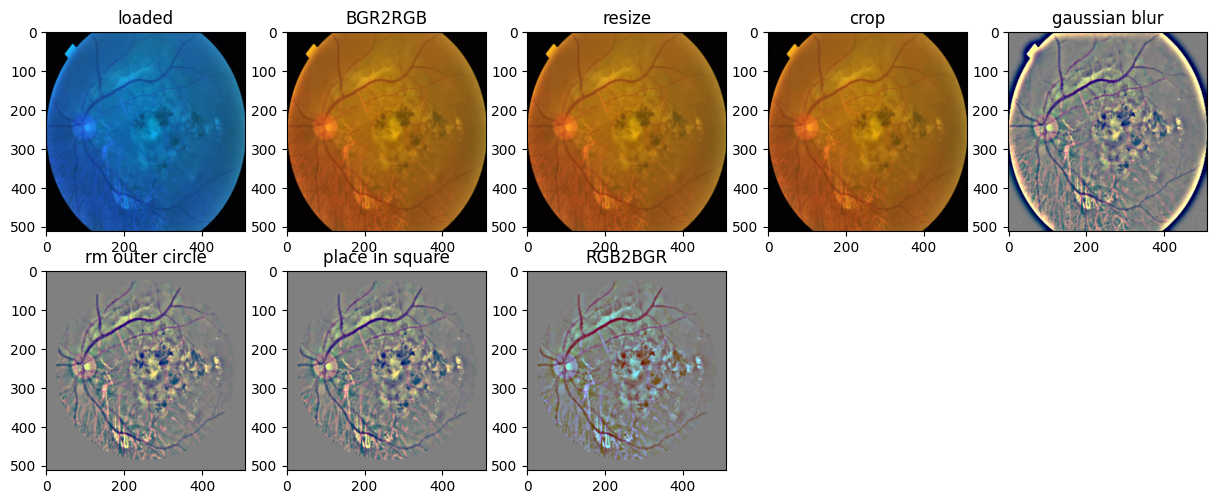

In [3]:
import os
input_folder="ODIR-2019/YOLO/preprocessed_merged"
output_folder="ODIR-2019/YOLO/processed_512ua_merged"
processor = ODIRImageProcessor(output_size=512)
image = "ODIR-2019/YOLO/preprocessed_merged/train/ageing/0_1kIM_6_ARMD.png"
processor.process(image, display=True)

In [4]:
!mkdir -p ODIR-2019/YOLO/processed_512ua_merged

In [5]:
import os
input_folder="ODIR-2019/YOLO/preprocessed_merged"
output_folder="ODIR-2019/YOLO/processed_512ua_merged"
processor = ODIRImageProcessor(output_size=512)

for root, dirs, files in os.walk(input_folder):
    for dir_name in dirs:
        source_dir=os.path.join(root, dir_name)
        target_dir=source_dir.replace(input_folder, output_folder)
        os.makedirs(target_dir, exist_ok=True)
        processor.process_folder(
            input_folder=source_dir,
            output_folder=target_dir,
            skip_if_exist=True,
            extension=".jpg"
        )
        processor.process_folder(
            input_folder=source_dir,
            output_folder=target_dir,
            skip_if_exist=True,
            extension=".png"
        )


Found 0 images to process
Found 0 images to process
Found 0 images to process
Found 0 images to process
Found 0 images to process
Found 0 images to process
Found 26 images to process
estimated radius 252.0 254.0
Saved processed image to: ODIR-2019/YOLO/processed_512ua_merged/val/cataract/2108_left.jpg
estimated radius 256.0 253.0
Saved processed image to: ODIR-2019/YOLO/processed_512ua_merged/val/cataract/294_left.jpg
estimated radius 255.5 255.5
Saved processed image to: ODIR-2019/YOLO/processed_512ua_merged/val/cataract/0_left.jpg
estimated radius 253.5 253.5
Saved processed image to: ODIR-2019/YOLO/processed_512ua_merged/val/cataract/2150_left.jpg
estimated radius 256.0 254.5
Saved processed image to: ODIR-2019/YOLO/processed_512ua_merged/val/cataract/2159_left.jpg
estimated radius 252.0 254.0
Saved processed image to: ODIR-2019/YOLO/processed_512ua_merged/val/cataract/1435_left.jpg
estimated radius 256.0 254.5
Saved processed image to: ODIR-2019/YOLO/processed_512ua_merged/val/cata